# Training Attempt 2


In [1]:
import os
from typing import List, Dict, Tuple
import functools

import librosa
import librosa.display
from librosa.core import load
import numpy as np
import IPython.display as ipd
import ipywidgets as ipw
from sklearn import metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchaudio
torchaudio.set_audio_backend("sox_io")
import pandas as pd
from tqdm import tqdm

from beat2d import settings

/home/jason/miniconda3/envs/beat2d/lib/python3.7/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [2]:
DATASET_PATH = "../data/oneshots"
CLASSES = {"none": 0, "kick": 1, "snare": 2}

In [3]:
def play(path: str, sr: int = settings.SAMPLE_RATE):
    s, _ = load(path, sr)
    return ipd.Audio(s, rate=settings.SAMPLE_RATE)

# Dataset

## Loading the Dataset

In [4]:
df = pd.read_csv("../data/oneshots/_index.csv")

## Labelling the Data

In [5]:
df_labelled = df.copy()
df_labelled["label"] = pd.NA
df_labelled.head(20)

,id,oneshot,source,start,end,label
0,ZfQAfZA8CHgiVJ8mUk4MgQ,../data/oneshots/ZfQAfZA8CHgiVJ8mUk4MgQ.wav,../data/recordings/kicks.wav,2048,14336,<NA>
1,94Qe9qWPFpmWnZKZ9amPhQ,../data/oneshots/94Qe9qWPFpmWnZKZ9amPhQ.wav,../data/recordings/kicks.wav,14336,26112,<NA>
2,3vxjeNCuVyWSKgcwsgEKBp,../data/oneshots/3vxjeNCuVyWSKgcwsgEKBp.wav,../data/recordings/kicks.wav,26112,37888,<NA>
3,EvhJRVwhW8o6bTe9Nd7p3M,../data/oneshots/EvhJRVwhW8o6bTe9Nd7p3M.wav,../data/recordings/kicks.wav,37888,45056,<NA>
4,h8XDzg3SjdjhQNdCfvcTRu,../data/oneshots/h8XDzg3SjdjhQNdCfvcTRu.wav,../data/recordings/kicks.wav,45056,50176,<NA>
5,kNboCiCPeFP3CgffugXpEb,../data/oneshots/kNboCiCPeFP3CgffugXpEb.wav,../data/recordings/kicks.wav,50176,56832,<NA>
6,EgguwTMD2fSQCjm3HtDF72,../data/oneshots/EgguwTMD2fSQCjm3HtDF72.wav,../data/recordings/kicks.wav,56832,61440,<NA>
7,WnN8u5LnCsXHXMxhBs5DLe,../data/oneshots/WnN8u5LnCsXHXMxhBs5DLe.wav,../data/recordings/kicks.wav,61440,67584,<NA>
8,7wj6egXESf97w4ZUadivFQ,../data/oneshots/7wj6egXESf97w4ZUadivFQ.wav,../data/recordings/kicks.wav,67584,73216,<NA>
9,cisjSQHSn2L4tD7QEJ7r5L,../data/oneshots/cisjSQHSn2L4tD7QEJ7r5L.wav,../data/recordings/kicks.wav,73216,84480,<NA>


In [6]:
def label_step(df: pd.DataFrame, index=0, recursive=True, unlabelled_only=False):
    ipd.clear_output()

    if index - 1 >= df.oneshot.count():
        print("Done labelling")
        return
    
    if unlabelled_only and not pd.isna(df.label[index]):
        while not pd.isna(df.label[index]):
            index += 1
        label_step(df, index+1, recursive, unlabelled_only)
        return
    
    oneshot = df.oneshot[index]
    audio, sr = librosa.core.load(oneshot, settings.SAMPLE_RATE)
    
    print(f"index: {index}, id: {df.id[index]}, file: {oneshot}\nlabel: {df.label[index]}")

    ipd.display(ipd.Audio(audio, rate=settings.SAMPLE_RATE, autoplay=True))

    buttons = []
    
    back_btn = ipw.Button(description="back")
    back_btn.on_click(lambda _: label_step(df, index-1, recursive))
    buttons.append(back_btn)
    
    for cls in CLASSES:
        def cb(label, *args):
            df.loc[index, "label"] = label
            label_step(df, index+1)
        
        btn = ipw.Button(description=cls)
        btn.on_click(functools.partial(cb, cls))
        buttons.append(btn)
    
    next_btn = ipw.Button(description="next")
    next_btn.on_click(lambda _: label_step(df, index+1, recursive))
    buttons.append(next_btn)
    
    ipd.display(ipw.HBox(buttons))

In [7]:
label_step(df_labelled, unlabelled_only=True)

index: 0, id: ZfQAfZA8CHgiVJ8mUk4MgQ, file: ../data/oneshots/ZfQAfZA8CHgiVJ8mUk4MgQ.wav
label: <NA>


In [8]:
df_labelled.label.value_counts()

Series([], Name: label, dtype: int64)

In [9]:
# Commented so we don't overwrite it
# df_labelled.to_csv("../data/oneshots/_labels.csv")

In [10]:
dataset = pd.read_csv("../data/oneshots/_labels.csv")

First I want to take a look at the average length of samples.

In [11]:
dataset.length = dataset.oneshot.apply(lambda o: (
    librosa.get_duration(librosa.core.load(o, sr=settings.SAMPLE_RATE)[0], settings.SAMPLE_RATE)
))

/home/jason/miniconda3/envs/beat2d/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


In [12]:
dataset.length.describe()

count    249.000000
mean       0.526471
std        0.299361
min        0.069660
25%        0.325079
50%        0.487619
75%        0.603719
max        2.693515
Name: oneshot, dtype: float64

Text(0, 0.5, 'Number of Samples')

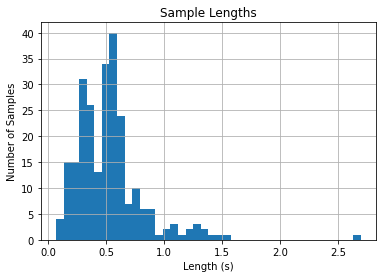

In [13]:
ax = dataset.length.hist(bins=40)
ax.set_title("Sample Lengths")
ax.set_xlabel("Length (s)")
ax.set_ylabel("Number of Samples")

# Computing Features

Next we'll use torchaudio to generate our features from the audio. I chose to use MEL Spectrograms to transform my data into another feature space.

In [14]:
def mel_spectrogram_layer(sr: int = settings.SAMPLE_RATE):
    return torchaudio.transforms.MelSpectrogram(
        sample_rate=sr,
        n_mels=70,
        normalized=True
    )

def compute_features(sample: np.ndarray, sr: int = settings.SAMPLE_RATE):
    return mel_spectrogram_layer()(torch.from_numpy(sample))

Now I'll get a list of each track.

In [15]:
nones = dataset[dataset.label == "none"]
kicks = dataset[dataset.label == "kick"]
snares = dataset[dataset.label == "snare"]

/home/jason/miniconda3/envs/beat2d/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370156314/work/aten/src/ATen/native/SpectralOps.cpp:653.)
  normalized, onesided, return_complex)
/home/jason/miniconda3/envs/beat2d/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370156314/work/aten/src/ATen/native/SpectralOps.cpp:590.)
  normalized, onesided, return_complex)


Text(0.5, 1.0, 'snare')

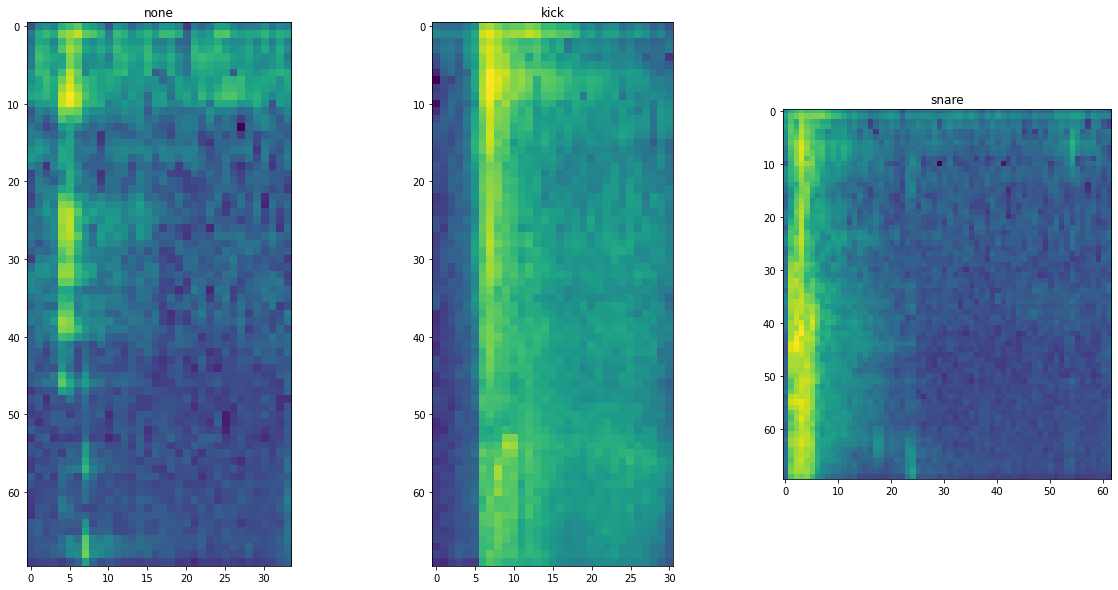

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(20, 10))

s = load(nones.sample(1).iloc[0].oneshot, settings.SAMPLE_RATE)[0]
melspec = compute_features(s, settings.SAMPLE_RATE)
ax1.imshow(melspec.log2().detach().numpy())
ax1.set_title("none")
                                    
s = load(kicks.sample(1).iloc[0].oneshot, settings.SAMPLE_RATE)[0]
melspec = compute_features(s, settings.SAMPLE_RATE)
ax2.imshow(melspec.log2().detach().numpy())
ax2.set_title("kick")

s = load(snares.sample(1).iloc[0].oneshot, settings.SAMPLE_RATE)[0]
melspec = compute_features(s, settings.SAMPLE_RATE)
ax3.imshow(melspec.log2().detach().numpy())
ax3.set_title("snare")

A human could probably identify each type of sample using the Mel Spectrogram, so our model should be pretty good at it too!

# Preprocessing Data

There's a couple things we need to do to preprocess our data before our model sees it:

1. Normalize the audio sample
2. Trim the sample to relevant audio
3. Crop or pad the sample to 0.5 seconds (11025 samples)

In [17]:
# We'll use this sample for all our preprocessing steps
# idx = 30
# idx = 55
idx = 238

s = load(dataset.iloc[idx].oneshot, settings.SAMPLE_RATE)[0]

print(dataset.iloc[idx].label)

ipd.Audio(s, rate=settings.SAMPLE_RATE)

snare


## Normalizing

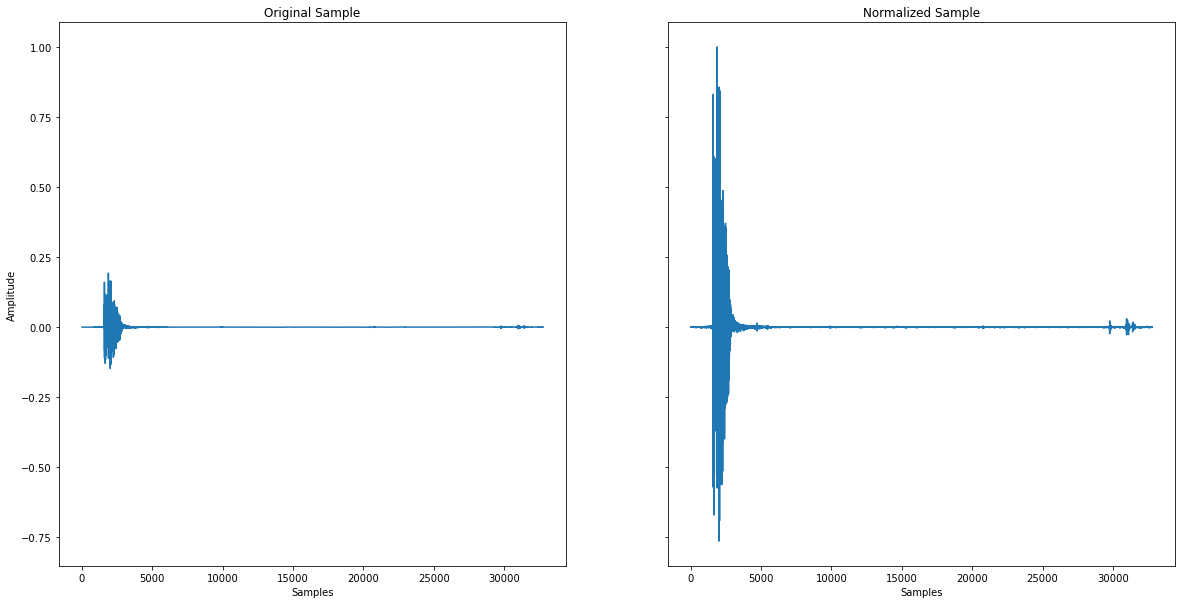

In [18]:
s_norm = librosa.util.normalize(s)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 10), sharey=True)

ax1.set_title("Original Sample")
ax1.set_ylabel("Amplitude")
ax1.set_xlabel("Samples")
ax1.plot(s)

ax2.set_title("Normalized Sample")
ax2.set_xlabel("Samples")
ax2.plot(s_norm)

## Trimming the Start and End

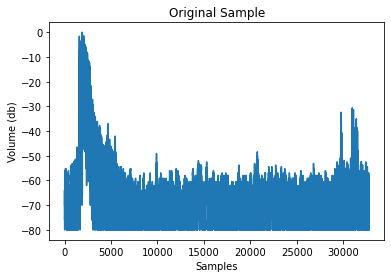

In [19]:
ax = plt.gca()

ax.set_title("Original Sample")
ax.set_ylabel("Volume (db)")
ax.set_xlabel("Samples")
ax.plot(librosa.core.amplitude_to_db(s_norm))

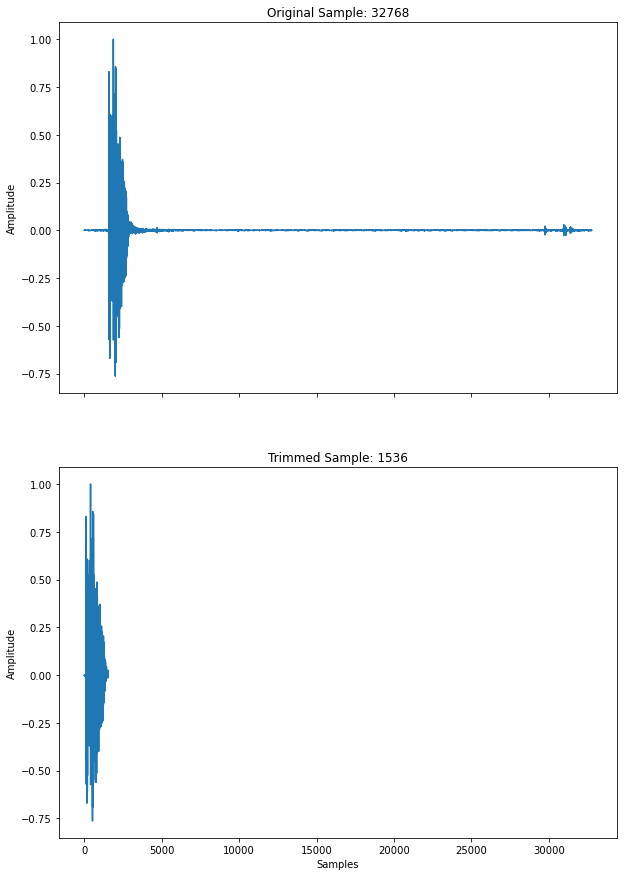

In [20]:
s_trim, trim_pts = librosa.effects.trim(s_norm, frame_length=256, hop_length=64, top_db=25)

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 15), sharex=True)

ax1.set_title(f"Original Sample: {s_norm.shape[0]}")
ax1.set_ylabel("Amplitude")
ax1.plot(s_norm)

ax2.set_title(f"Trimmed Sample: {s_trim.shape[0]}")
ax2.set_ylabel("Amplitude")
ax2.set_xlabel("Samples")
ax2.plot(s_trim)

In [21]:
trimmed_lengths = dataset.oneshot.apply(lambda o: (
    librosa.get_duration(librosa.effects.trim(librosa.util.normalize(librosa.core.load(o, sr=settings.SAMPLE_RATE)[0]), frame_length=256, hop_length=64, top_db=20)[0], settings.SAMPLE_RATE)
))

In [22]:
trimmed_lengths.describe()

count    249.000000
mean       0.158646
std        0.150924
min        0.014512
25%        0.058050
50%        0.101587
75%        0.185760
max        0.743039
Name: oneshot, dtype: float64

<AxesSubplot:>

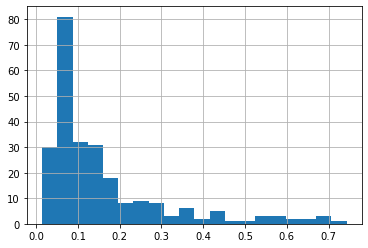

In [23]:
trimmed_lengths.hist(bins=20)

From this, I'm comfortable clipping at 0.2 seconds.

## Clipping and Padding to 0.2 Seconds

In [24]:
max_clip_length = librosa.core.time_to_samples(0.2)

In [25]:
s_dest = np.zeros(max_clip_length, dtype=np.float32)

clip_length = min(max_clip_length, s_trim.shape[0])
s_dest[:clip_length] = s_trim[:clip_length]

In [26]:
compute_features(s_dest).shape

torch.Size([70, 23])

torch.Size([70, 23])


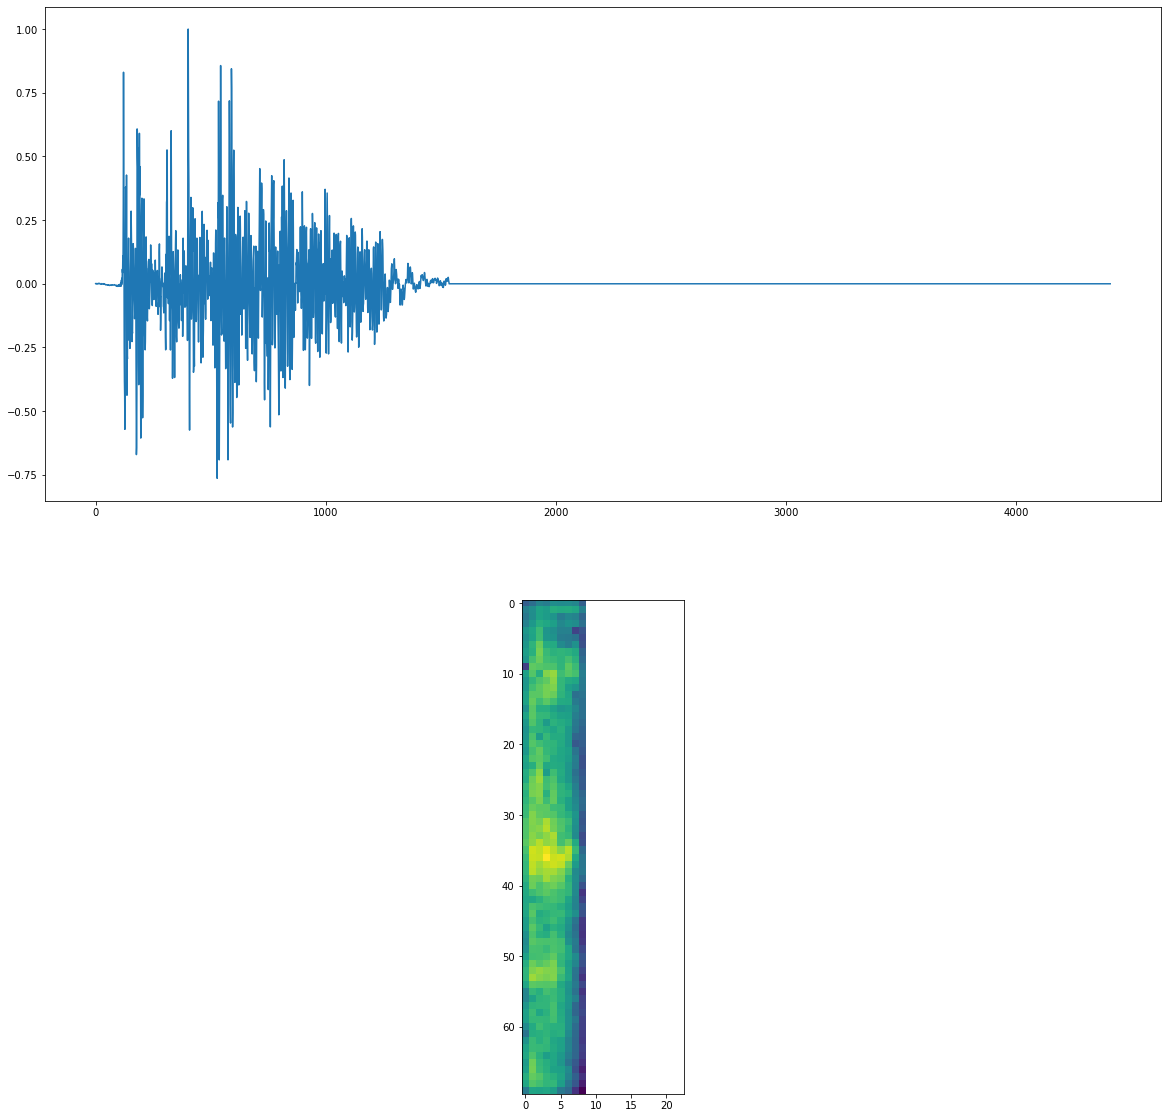

In [27]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(20, 20))

melspec = compute_features(s_dest)
print(melspec.shape)

ax1.plot(s_dest)
ax2.imshow(melspec.log2().detach().numpy())

## Combining it into One Function

In [28]:
MAX_CLIP_LENGTH = librosa.core.time_to_samples(0.2)

def preprocess_sample(sample: np.ndarray):
    # Normalize the audio
    s_norm = librosa.util.normalize(sample)
    
    # Trim silence
    s_trim = librosa.effects.trim(s_norm, frame_length=256, hop_length=64, top_db=25)[0]
    
    # Clip or pad to MAX_CLIP_LENGTH
    s_dest = np.zeros(MAX_CLIP_LENGTH, dtype=np.float32)
    clip_length = min(MAX_CLIP_LENGTH, s_trim.shape[0])
    s_dest[:clip_length] = s_trim[:clip_length]
    
    return s_dest

# Building our Model

In [29]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.melspec = mel_spectrogram_layer()
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)

        self.fc1 = nn.Linear(16 * 16 * 4, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 3)

    def forward(self, x):
        x = self.melspec(x)
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, 16 * 16 * 4)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.dropout(x, 0.33)
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        
        return x
    
    def predict(self, x):
        x = self.forward(x)
        
        return int(F.softmax(x, dim=1).argmax())

In [30]:
net = Net()

In [31]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001, weight_decay=0.001)

# Preparing Training Data

In [32]:
class BeatboxDataset(torch.utils.data.Dataset):
    def __init__(self, df: pd.DataFrame):
        self.df = df
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        row = self.df.iloc[idx]
        
        waveform = load(row.oneshot, settings.SAMPLE_RATE)[0]
        waveform = preprocess_sample(waveform)
        
        waveform_tensor = torch.from_numpy(waveform).view(1, 4410)
        
        return waveform_tensor, CLASSES[row.label]

In [33]:
train, test = train_test_split(dataset, test_size=0.25, shuffle=True)

In [34]:
train_set = BeatboxDataset(train)
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=8, shuffle=True)

test_set = BeatboxDataset(test)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=8)

In [35]:
data, label = next(iter(train_dataloader))

example_forward = net.forward(data[0].unsqueeze(0))

In [36]:
data[0].shape

torch.Size([1, 4410])

In [ ]:
class Metric:
    def __init__(self, evaluation_func):
        self.evaluation_func = evaluation_func
        
        self.last = 0.0
        self.epoch_history = []
        self.history = []
        self.min = float('inf')
        self.max = 0.0
    
    def update(self, labels, predictions):
        val = float(self.evaluation_func(labels, predictions))
        self.epoch_history.append(val)
        
    def epoch_start(self):
        if len(self.epoch_history) > 0:
            epoch_val = np.mean(self.epoch_history)

            self.min = min(self.min, epoch_val)
            self.max = max(self.max, epoch_val)
            self.history.append(epoch_val)
            self.last = epoch_val

            self.epoch_history = []
        

class Evaluator:
    def __init__(self, metrics_dict):
        self.metrics = metrics_dict
    
    def update(self, labels, predictions):
        for metric in self.metrics.values():
            metric.update(labels, predictions)
    
    def epoch_start(self):
        for metric in self.metrics.values():
            metric.epoch_start()
    
    def metrics_string(self):
        output = ""
        for name, metric in self.metrics.items():
            output += f"{name}: {metric.last:04f} "
        return output
    

class EarlyStopping:
    def __init__(self, patience):
        self.patience = patience
        self.counter = 0
    
    def should_stop(self, compare):
        if compare:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        else:
            self.counter = 0

In [ ]:
def train_epoch(dataloader: torch.utils.data.DataLoader, evaluator: Evaluator):
    total_loss = 0.0
    for batch_i, data in enumerate(dataloader):
        inputs, labels = data
        
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()
        
        total_loss += loss.item()
        
        evaluator.update(labels, outputs)
    
    return total_loss / len(dataloader)

In [ ]:
epochs = 100
early_stop = EarlyStopping(10)

train_evaluator = Evaluator({
    "loss": Metric(lambda labels, preds: nn.CrossEntropyLoss()(preds, labels)),
    "acc": Metric(lambda labels, preds: metrics.accuracy_score(labels, [int(p.argmax()) for p in preds.detach().numpy()])),
    "prec": Metric(lambda labels, preds: metrics.precision_score(labels, [int(p.argmax()) for p in preds.detach().numpy()], average="weighted")),
    "recall": Metric(lambda labels, preds: metrics.recall_score(labels, [int(p.argmax()) for p in preds.detach().numpy()], average="weighted")),
    "f1": Metric(lambda labels, preds: metrics.f1_score(labels, [int(p.argmax()) for p in preds.detach().numpy()], average="weighted"))
})

val_evaluator = Evaluator({
    "loss": Metric(lambda labels, preds: nn.CrossEntropyLoss()(preds, labels)),
    "acc": Metric(lambda labels, preds: metrics.accuracy_score(labels, [int(p.argmax()) for p in preds.detach().numpy()])),
    "prec": Metric(lambda labels, preds: metrics.precision_score(labels, [int(p.argmax()) for p in preds.detach().numpy()], average="weighted")),
    "recall": Metric(lambda labels, preds: metrics.recall_score(labels, [int(p.argmax()) for p in preds.detach().numpy()], average="weighted")),
    "f1": Metric(lambda labels, preds: metrics.f1_score(labels, [int(p.argmax()) for p in preds.detach().numpy()], average="weighted"))
})

for i in range(epochs):
    print("Epoch", i)
    
    train_evaluator.epoch_start()
    
    net.train()
    train_loss = train_epoch(train_dataloader, train_evaluator)
    
    print(f"Training:  ", train_evaluator.metrics_string())
    
    net.eval()
    test_loss = 0.0
    
    val_evaluator.epoch_start()
    
    with torch.no_grad():
        for data in test_dataloader:
            inputs, labels = data
            outputs = net(inputs)
            
            loss = criterion(outputs, labels)
            
            val_evaluator.update(labels, outputs)
            
    print(f"Validation:", val_evaluator.metrics_string())
    
    if early_stop.should_stop(val_evaluator.metrics["loss"].last > val_evaluator.metrics["loss"].min):
        print("Early Stopping...")
        break

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))

ax.set_facecolor("white")

ax.set_title("Training Metrics")
ax.set_xlabel("Epoch")

ax.plot(train_evaluator.metrics["loss"].history, label="train_loss")
ax.plot(train_evaluator.metrics["acc"].history, label="train_acc")
ax.plot(train_evaluator.metrics["f1"].history, label="train_f1")

ax.plot(val_evaluator.metrics["loss"].history, label="val_loss")
ax.plot(val_evaluator.metrics["acc"].history, label="val_acc")
ax.plot(val_evaluator.metrics["f1"].history, label="test_f1")

ax.legend()

In [ ]:
# torch.save(net.state_dict(), "../models/model.pth")

In [ ]:
# To load into memory
# model = Net()
# model.load_state_dict(torch.load("../models/model.pth"))
# model.eval()

# Testing our Final Model

In [38]:
from beat2d import model

In [41]:
m = model.load_model()

In [42]:
dataset.loc[dataset.id == "Q7gFWKMVBsFBQ47WW5qhFA"]

,Unnamed: 0,id,oneshot,source,start,end,label
227,227,Q7gFWKMVBsFBQ47WW5qhFA,../data/oneshots/Q7gFWKMVBsFBQ47WW5qhFA.wav,../data/recordings/snare.wav,1142272,1148928,none


In [43]:
def predict_play_random_example(df: pd.DataFrame, m: model.Model, label: str, sr: int = settings.SAMPLE_RATE):
    ex = test[test.label == label].sample(1).iloc[0]
    
    X, sr = load(ex.oneshot, settings.SAMPLE_RATE)

    pred = m.predict(X)

    print(ex.id, pred, ex.label)

    ipd.display(ipd.Audio(X, rate=settings.SAMPLE_RATE))

In [44]:
predict_play_random_example(test, m, "none")

WgYzruGePVrKnHM65989bS CLASSES.NONE none


In [45]:
predict_play_random_example(test, m, "kick")

3gh5t9PZnp44C4XLEtb2MY CLASSES.KICK kick


In [46]:
predict_play_random_example(test, m, "snare")

Pgk5WcRFFfshkcGs6YhNqY CLASSES.SNARE snare


# Testing with iPhone Recordings

Using a totally different microphone and environment, I want to see if our model can handle the change in data.

The main steps we have to go to go from recording to MIDI are:

1. Split the audio by onsets
2. Predict the class of each oneshot
3. Transform the timestamp, amplitude, and label information to MIDI

In [49]:
from beat2d import slicing

In [50]:
m = model.load_model()

In [55]:
s, sr = load("../data/test/iphone01.m4a", settings.SAMPLE_RATE)
ipd.Audio(s, rate=sr)

/home/jason/miniconda3/envs/beat2d/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [51]:
slices, slice_pts = slicing.split_oneshots(s, sr)

In [54]:
for slc in slices:
    pred = m.predict(slc)
    print(pred)
    ipd.display(ipd.Audio(slc, rate=sr))
    input()
    ipd.clear_output()

In [57]:
s, sr = load("../data/test/iphone02.m4a", settings.SAMPLE_RATE)
ipd.display(ipd.Audio(s, rate=sr))

slices, slice_pts = slicing.split_oneshots(s, sr)

/home/jason/miniconda3/envs/beat2d/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [58]:
for slc in slices:
    pred = m.predict(slc)
    print(pred)
    ipd.display(ipd.Audio(slc, rate=sr))
    input()
    ipd.clear_output()

CLASSES.KICK


KeyboardInterrupt: Interrupted by user